In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import time

In [9]:
print("🔹 Checking GPU availability...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

start_time = time.time()  

🔹 Checking GPU availability...
✅ Using device: cuda


In [3]:
print("\n🔹 Loading CIFAR-10 dataset...")

transform = transforms.Compose([
    transforms.Resize((224, 224)),     # Match VGG16 input
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root=r"D:\DLT", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root=r"D:\DLT", train=False, download=True, transform=transform)

# Smaller subset for faster demo (optional)
subset_size = 5000
train_dataset, _ = torch.utils.data.random_split(train_dataset, [subset_size, len(train_dataset) - subset_size])
test_dataset, _ = torch.utils.data.random_split(test_dataset, [1000, len(test_dataset) - 1000])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"✔ Dataset loaded successfully! Train: {len(train_dataset)}, Test: {len(test_dataset)}")



🔹 Loading CIFAR-10 dataset...
Files already downloaded and verified
Files already downloaded and verified
✔ Dataset loaded successfully! Train: 5000, Test: 1000


In [4]:
print("\n🔹 Loading Pre-trained VGG16 model...")
model = models.vgg16(weights='IMAGENET1K_V1')

# Freeze convolutional layers
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier head
model.classifier = nn.Sequential(
    nn.Linear(25088, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 10)  # 10 CIFAR-10 classes
)

model = model.to(device)
print("✔ Model ready!")



🔹 Loading Pre-trained VGG16 model...
✔ Model ready!


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

In [6]:
print("\n🔹 Starting training...")
num_epochs = 3
train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)

    # Validation
    model.eval()
    val_correct, val_total, val_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    val_loss = val_loss / len(test_loader)
    val_acc_history.append(val_acc)
    val_loss_history.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

print("\n✔ Training complete!")


🔹 Starting training...
Epoch [1/3] | Train Loss: 1.1329 | Train Acc: 63.88% | Val Loss: 0.7198 | Val Acc: 78.50%
Epoch [2/3] | Train Loss: 0.5130 | Train Acc: 85.08% | Val Loss: 0.6050 | Val Acc: 80.30%
Epoch [3/3] | Train Loss: 0.3202 | Train Acc: 91.72% | Val Loss: 0.5577 | Val Acc: 81.10%

✔ Training complete!


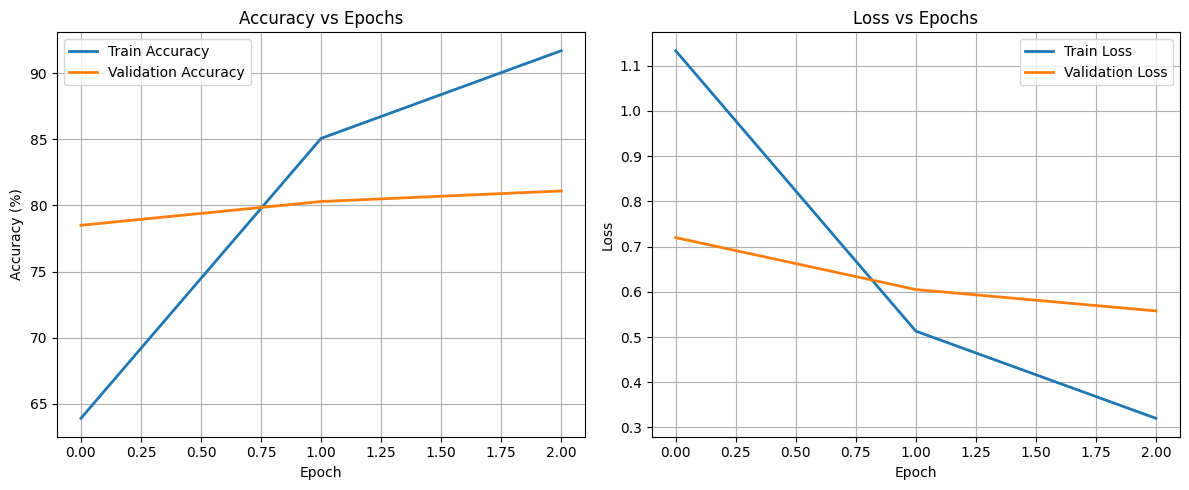

In [7]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Train Accuracy', linewidth=2)
plt.plot(val_acc_history, label='Validation Accuracy', linewidth=2)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Train Loss', linewidth=2)
plt.plot(val_loss_history, label='Validation Loss', linewidth=2)
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
print("\n🔹 Evaluating model performance...")
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("\n📊 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=[
    'airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'
]))

print("\n📈 Confusion Matrix:\n")
print(confusion_matrix(all_labels, all_preds))

print("\n✅ Total Execution Time: {:.2f} seconds".format(time.time() - start_time))


🔹 Evaluating model performance...

📊 Classification Report:

              precision    recall  f1-score   support

    airplane       0.80      0.87      0.83        89
  automobile       0.93      0.90      0.92       102
        bird       0.78      0.72      0.75        98
         cat       0.69      0.69      0.69       105
        deer       0.71      0.79      0.75       103
         dog       0.75      0.73      0.74        93
        frog       0.83      0.81      0.82       106
       horse       0.86      0.79      0.82       109
        ship       0.83      0.95      0.89        96
       truck       0.95      0.88      0.91        99

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000


📈 Confusion Matrix:

[[77  0  2  1  0  0  0  0  7  2]
 [ 2 92  0  2  0  0  1  0  4  1]
 [ 3  0 71  3 11  3  1  6  0  0]
 [ 2  1  7 72  7  7  6  1  1  1]
 [ 4  1  3  4 81  1  5  4